# This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

## Update the John Hopkins, Covid-19 data 
https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. 

In [8]:
# import libraries
import numpy as np
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

## Prepare arguments for driver

In [9]:
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\Documents\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'USA',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\Documents\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (7,2,2), 
            'order_list': [],
            'p_values': range(5,10),
            'd_values': range(1,3),
            'q_values': range(1,3),
            'split_value': .5,
            'bias': 0, # First time thru bias is 0
            'date': '03-31-2021'}

## Load John Hopkins data

The "data date" is 2021-01-08 00:00:00

ADF Statistic: -0.824016
p-value: 0.811966
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


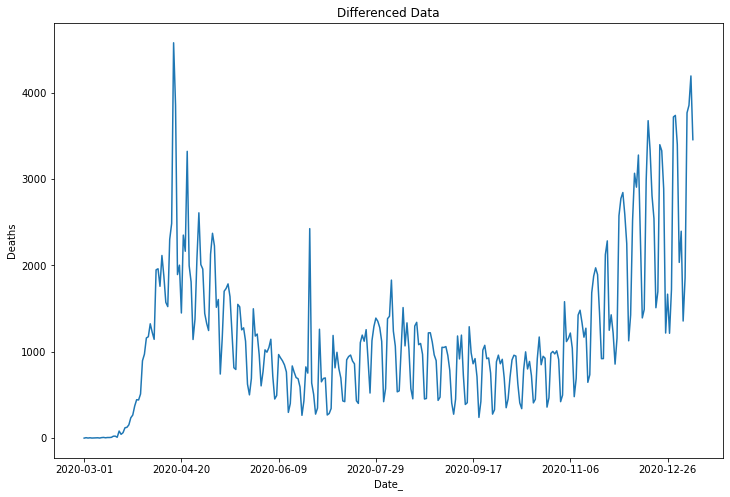

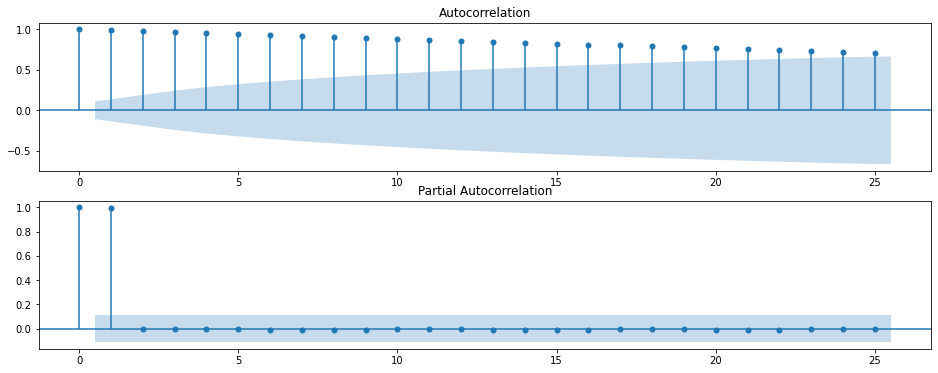

RMSE is 382.894 with ARIMA of (5, 2, 1)
RMSE is 346.348 with ARIMA of (6, 2, 1)
RMSE is 331.319 with ARIMA of (8, 2, 1)
RMSE is 331.181 with ARIMA of (9, 2, 1)

Best RMSE Score is 331.181 with ARIMA of (9, 2, 1)

RMSE: 331.181
       Residual Statistics
count           158.000000
mean             32.579411
std             330.622918
min           -1453.972380
25%            -160.382847
50%              -0.932358
75%             169.903877
max             992.861218


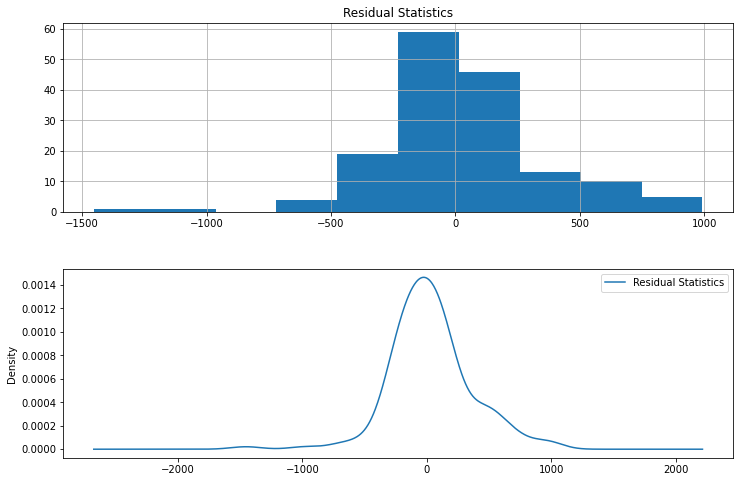


bias IS saved in arg_dict["bias"] for subsequent run is: 32.579411475385186 


RMSE: 329.575
       Residual Statistics
count         1.580000e+02
mean         -1.013108e-11
std           3.306229e+02
min          -1.486552e+03
25%          -1.929623e+02
50%          -3.351177e+01
75%           1.373245e+02
max           9.602818e+02


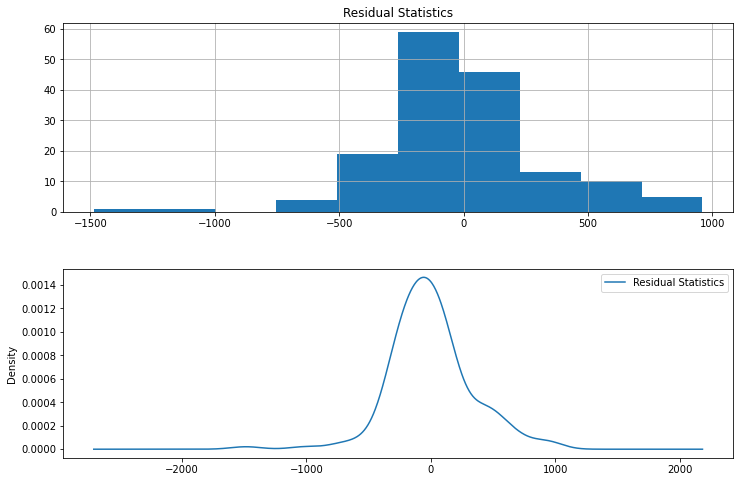


bias NOT saved in arg_dict["bias"] for subsequent run is: -1.013108022228072e-11 



In [10]:
df, li_set = ld.driver(arg_dict)

# Get the date of the last file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
order_list = ags.driver(df, arg_dict)
arg_dict.update({'order_list': order_list})
arg_dict.update({'best_cfg': order_list[0]})

# summarize residual errors for an ARIMA model and return bias
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Plot test (actual) vs predictions, save, and forecast

The predicted cumulative Deaths for USA for tomorrow (input data plus 1 day) are 368,223


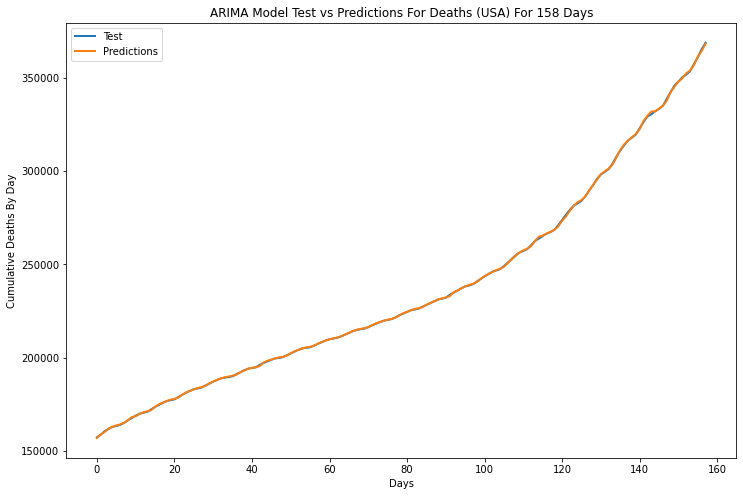

In [11]:
tpsf1.driver(arg_dict)

NB The above prediction of a single day in the future will only rarely match the the first day in the multi step forecast below. The reason is that the ARIMA model is a moving average model. The specific days included in the moving average change in the multi step forecast. 

## Multi Step Forecast

The USA prediction is for 688,370 cumulative Deaths to occur by 2021-03-31 00:00:00


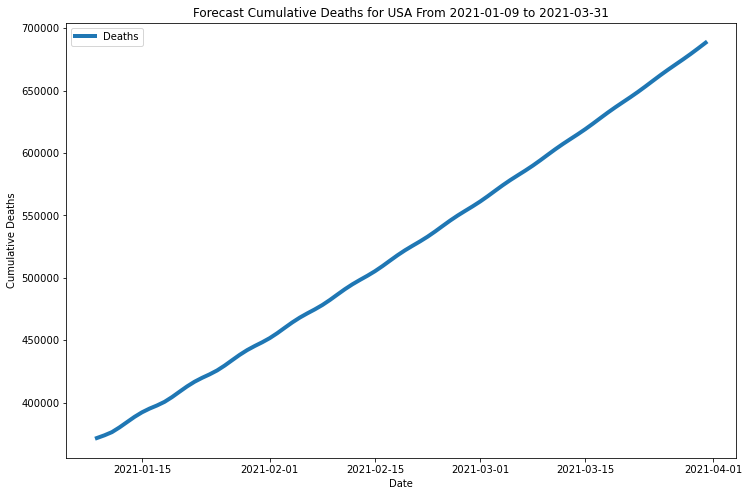

In [12]:
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

## Actual
If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to have no more instances by the date indicated. We truncate the prediction at that point. 

In [13]:
new_col = "Daily_" + arg_dict['dependent_variable']
df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
print('Actual')
df.tail(14) 

Actual


,Deaths,Daily_Deaths
Date_,,
2020-12-26,332068.0,1667.0
2020-12-27,333282.0,1214.0
2020-12-28,335003.0,1721.0
2020-12-29,338722.0,3719.0
2020-12-30,342459.0,3737.0
2020-12-31,345859.0,3400.0
2021-01-01,347894.0,2035.0
2021-01-02,350290.0,2396.0
2021-01-03,351646.0,1356.0


## 14 Day Forecast

In [14]:
forecast_df[new_col] = forecast_df[arg_dict['dependent_variable']] - forecast_df[arg_dict['dependent_variable']].shift()
forecast_df.iloc[0,1] = forecast_df.iloc[0,0] - df.iloc[-1,0]
print('Predicted')
forecast_df.head(14)

Predicted


,Deaths,Daily_Deaths
Date_,,
2021-01-09,371613.0,2840.0
2021-01-10,373779.0,2166.0
2021-01-11,376337.0,2558.0
2021-01-12,380115.0,3778.0
2021-01-13,384332.0,4217.0
2021-01-14,388541.0,4209.0
2021-01-15,392213.0,3672.0
2021-01-16,395180.0,2967.0
2021-01-17,397703.0,2523.0


## Conclusions

- The code is quite flexible. It accepts any feature and will predict the values based on it. 

## Limitations

ARIMA is very sensitive to the most recent data. This is a feature of ARIMA models. This is probably not the best for long term predictions. However, it is also probably the best that we can do right now.